<a href="https://colab.research.google.com/github/piyushsoni27/CNN_web/blob/master/CNN_train_test/CNN_train_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
"""
import os

os.chdir("drive/My Drive/Google colab projects/CNN_web")
"""

'\nimport os\n\nos.chdir("drive/My Drive/Google colab projects/CNN_web")\n'

In [0]:
patches_dir = "cifar-10-batches-py/"

#imports

In [0]:
import numpy as np
import pickle
import os
import cv2

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import scipy
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

##Parameters to be set

In [0]:
## Minimum input image shape is (75, 75, 3) for inceptionV3 model.
input_size = (75, 75, 3)

num_classes = 10

##Download and load pre-trained *Inception V3* model

In [26]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2019-05-19 13:54:06--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.129.128, 2607:f8b0:4001:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.129.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   170MB/s    in 0.5s    

2019-05-19 13:54:07 (170 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

## Minimum input image shape is (75, 75, 3) for inceptionV3 model.

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=input_size, include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

##Loading and preparing data 

In [0]:
def load_cifar10_train_batch_util(batch_id):

    with open(os.path.join('cifar-10-batches-py','data_batch_' 
              + str(batch_id)), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features_batch = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels_batch = batch['labels']
    
    return features_batch, labels_batch

def load_train_data(im_shape = (32,32,3), one_hot_labels = True, num_classes = num_classes):
    features = np.zeros(shape = (50000, 32, 32, 3), dtype = np.uint8)
    labels = []

    for batch_id in range(1,6):
        x, y = load_cifar10_train_batch_util(batch_id)
        features[10000*(batch_id-1) : 10000*batch_id] = x
        labels.extend(y)
    
    if(one_hot_labels is True):
        labels = to_categorical(labels, num_classes)
    
    if(im_shape is not (32,32,3)):
      
      features_new = np.empty(shape=(features.shape[0],)+im_shape, dtype=np.uint8)
      for idx in range(features.shape[0]):
          features_new[idx] = scipy.misc.imresize(features[idx], im_shape)
      
      return features_new, labels
    
    else:
        return features, labels
      
def load_test_data(im_shape = (32,32,3)):
    
    with open(os.path.join('cifar-10-batches-py','test_batch'), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
    
    if(im_shape is not (32,32,3)):
      
      features_new = np.empty(shape=(features.shape[0],)+im_shape, dtype=np.uint8)
      for idx in range(features.shape[0]):
          features_new[idx] = scipy.misc.imresize(features[idx], im_shape)
      
      return features_new
    
    else:
      return features

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


(10000, 75, 75, 3)
50000
(75, 75, 3)
5
253


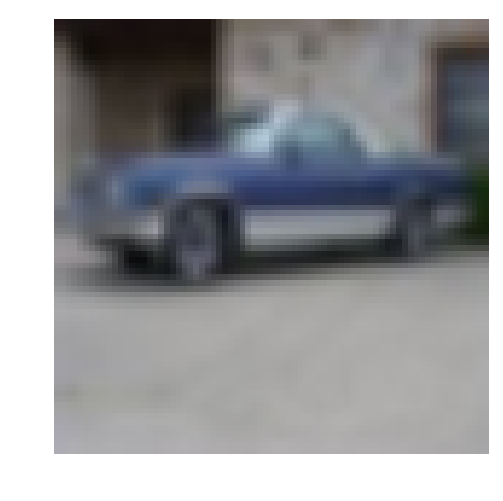

label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [31]:
x, y = load_train_data(im_shape = input_size)
x_test = load_test_data(im_shape = input_size)

print(x_test.shape)
print(len(y))
print(x[10000].shape) 

print(x[1].min())
print(x[1].max())

plt.axis('off')
plt.imshow(x[10000])
plt.show()

print("label: {}".format(y[10000]))

In [0]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)


# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(x_train,  y_train)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = val_datagen.flow(x_val, y_val)

In [34]:
for layer in pre_trained_model.layers:
  layer.trainable = False
  
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 3, 3, 768)


In [35]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(num_classes, activation='softmax')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [36]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)



Instructions for updating:
Use tf.cast instead.
Epoch 1/2
313/313 [==============================] - 7s 23ms/step - loss: 2.4177 - acc: 0.5533
 - 79s - loss: 1.3743 - acc: 0.5406 - val_loss: 2.4177 - val_acc: 0.5533
Epoch 2/2
313/313 [==============================] - 7s 22ms/step - loss: 2.5849 - acc: 0.5571
 - 72s - loss: 1.1631 - acc: 0.6035 - val_loss: 2.5849 - val_acc: 0.5571


##Further Improving Accuracy with Fine-Tuning
* Re-train only top layers of *Inception V3* model

In [0]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(
                  lr=0.001, 
                  momentum=0.9),
              metrics=['acc'])

In [40]:
history_finetune = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/50
313/313 [==============================] - 8s 26ms/step - loss: 2.5810 - acc: 0.5851
 - 78s - loss: 1.0439 - acc: 0.6395 - val_loss: 2.5810 - val_acc: 0.5851
Epoch 2/50
313/313 [==============================] - 6s 20ms/step - loss: 2.9811 - acc: 0.5488
 - 73s - loss: 0.9663 - acc: 0.6619 - val_loss: 2.9811 - val_acc: 0.5488
Epoch 3/50
313/313 [==============================] - 6s 20ms/step - loss: 2.8420 - acc: 0.5636
 - 75s - loss: 0.9227 - acc: 0.6776 - val_loss: 2.8420 - val_acc: 0.5636
Epoch 4/50
313/313 [==============================] - 6s 20ms/step - loss: 2.7184 - acc: 0.5710
 - 74s - loss: 0.8855 - acc: 0.6921 - val_loss: 2.7184 - val_acc: 0.5710
Epoch 5/50
313/313 [==============================] - 6s 20ms/step - loss: 2.8598 - acc: 0.5657
 - 76s - loss: 0.8645 - acc: 0.6984 - val_loss: 2.8598 - val_acc: 0.5657
Epoch 6/50
313/313 [==============================] - 6s 20ms/step - loss: 2.6104 - acc: 0.5809
 - 75s - loss: 0.8380 - acc: 0.7052 - val_loss: 2.6104 - va

https://www.pyimagesearch.com/2018/12/10/keras-save-and-load-your-deep-learning-models/

Text(0.5, 1.0, 'Training and validation loss')

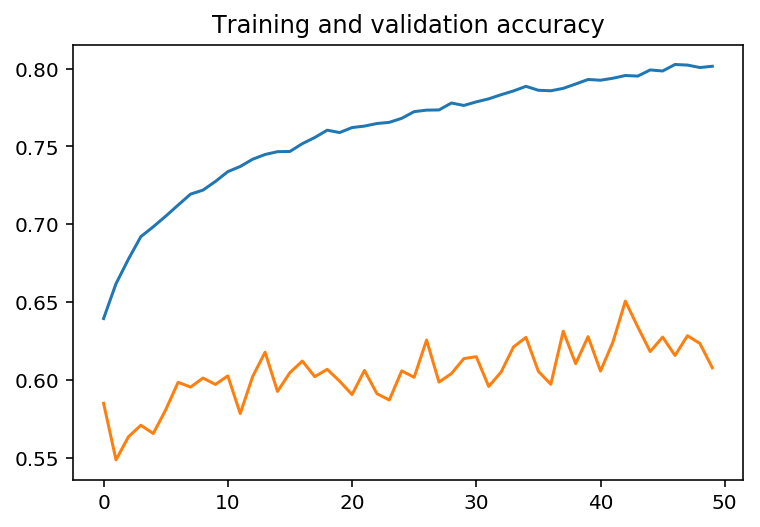

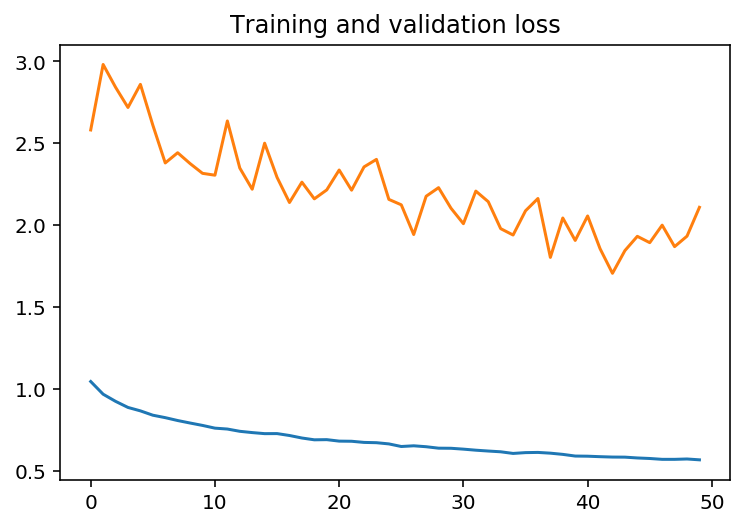

In [43]:


%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history_finetune.history['acc']
val_acc = history_finetune.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [0]:
model.save('architecure.h5')